### Transfer Learning, Convolutions, and Object Localisation in Keras) - Deep Learning

### Part 1
#### Dataset
The dataset selected contains the images of lion and tiger. These two animal have a similar kind of body and color, the texture on the body and face is different. All the images are of 512/512 pixels resolution.The size of images of both classes is changed to (180,180) while training and testing. The link for the dataset is:
https://drive.google.com/drive/folders/19qBHntILkskqKoqohjQ_Qg1_zj2UTbs2?usp=sharing

Method used for the collection of the images is the Image dataset tool (IDT), this tool makes it easier and quicker to download images of a particular class just by passing the keywords. IDT also gives the options to select the resolution, desired image size and the search engine(like Duck Go, Bing etc) for the images. The sample image of each class is shown below:

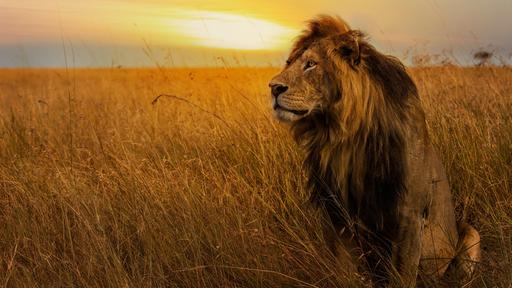

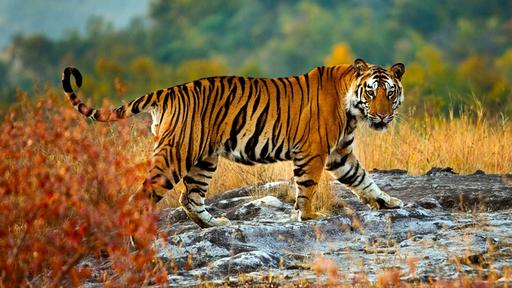

In [1]:
#Import packages
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from keras import models
from scipy.stats import pearsonr
from keras.layers import Dense,Dropout, Input, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential, Model

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

ImageDataGenerator is used to split the data into training, validation and testing with proper data augmentation

In [2]:
#https://keras.io/api/preprocessing/image/
directory =  "data\\train" 
train_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, 
    validation_split=0.3)

train_generator = train_datagen.flow_from_directory( #training data
        directory,
        target_size=(180, 180),
        batch_size=32,
        class_mode='binary',
        subset='training',
        shuffle=True)
validation_generator = train_datagen.flow_from_directory(#validation data
        directory,
        target_size=(180, 180),
        batch_size=32,
        class_mode='binary',
        subset='validation',
        shuffle=True)

directory =  "data\\test"
test_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(#testing data
        directory,
        target_size=(180, 180),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

Found 644 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


### Part 2

#### InceptionV3

The inceptionv3 model is widely used for the image data classification. This model was published in the paper 'Rethinking the Inception Architecture for Computer Vision'. The model is economical in terms of memory and includes the techniques like factorized convulutions,dimension reduction and regularization.

Base Model Output layer is 'mixed10', the output shape of this layer is (None, 4, 4, 2048). This layer is connected to 4 other layers in the model activation_86[0][0], mixed9_1[0][0], concatenate_2[0][0] and activation_94[0][0].
There are three layers added to the base model:
1. GlobalAveragePoooling2D - This layer will pool the data by averaging it in 2D for better representation.
2. Dropout - Dropout layer is added to avoid overfitting of data. It will randomly set the input units to 0 with a frequency of 0.1.
3. Sigmoid activation - The activation layer is added in the end to get the single output 0/1.

The epochs are 5 and workers are set to 8. Binary accuracy is selected as the accuracy metric.The final accuracy of training is 94.7% and validation is 94.5%.

In [3]:
#Load a pre-trained model (InceptionV3)
base_model = tf.keras.applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(180,180,3))
# Freeze the base model
base_model.trainable = False

#adding layers to the base model
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.1))
add_model.add(Dense(1, activation='sigmoid'))
model = add_model
#model summary
print(model.summary())

#compiling the model with binary accuracy as metric
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],)

#fitting the model
history = model.fit_generator(generator=train_generator,
                  epochs=5,workers=8,
                validation_data=validation_generator)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________
None


C:\Users\kashi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
21/21 [==============================] - 24s 938ms/step - loss: 0.7790 - binary_accuracy: 0.6603 - val_loss: 0.1820 - val_binary_accuracy: 0.9309
Epoch 2/5
21/21 [==============================] - 17s 821ms/step - loss: 0.2124 - binary_accuracy: 0.9166 - val_loss: 0.1969 - val_binary_accuracy: 0.9382
Epoch 3/5
21/21 [==============================] - 18s 814ms/step - loss: 0.2400 - binary_accuracy: 0.8967 - val_loss: 0.1496 - val_binary_accuracy: 0.9418
Epoch 4/5
21/21 [==============================] - 18s 823ms/step - loss: 0.1473 - binary_accuracy: 0.9362 - val_loss: 0.1089 - val_binary_accuracy: 0.9600
Epoch 5/5
21/21 [==============================] - 17s 802ms/step - loss: 0.1654 - binary_accuracy: 0.9476 - val_loss: 0.1179 - val_binary_accuracy: 0.9455


###### Plots for accuracy and loss
The first plot shows us accuracy of training set and validation set, as we see in 5 epochs with training data, accuracy increases from 0.66 to 0.94 approximately. On the other hand validation set gave us accuracy score around 0.93 in the start and increased around 0.94 after 5 epochs. It becomes constant after three epochs.

The second plot is of loss which shows us that training data loss has sudden drop in start and remains constant as we move ahead in cycles while loss in validation set remains almost constant.

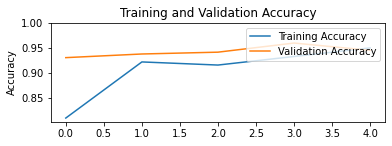

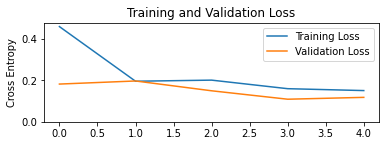

In [4]:
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#accuracy plot
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()
 
#validation plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

##### Test dataset results
The classification is then carried out with testing data which is unseen for the model.
The accuracy on the test set is 95%.

In [5]:
pred = model.predict(test_generator)
pred_1 = np.round(pred)
loss, acc = model.evaluate(test_generator)
print(acc)
print(loss)

3/3 [==============================] - 2s 460ms/step - loss: 0.0883 - binary_accuracy: 0.9540
0.954023003578186
0.08832859992980957


### Part 3

Step 1: Extracting the output of the output layer of base model(mixed10), the features of the output layer is extracted using get_layer function. GlobalAveragePooling2D and Softmax layers are added after that to get a scalar output.

Step 2: Calculate the correlation using pearsonr by passing the scalar output of each neuron and the actual labels of the images. The output of pearsonr is stored in a list.

Step 3: Sort the list and select top 3 neurons with the highest correlation. These neurons contribute the most to detect the class labels.

In this iteration the highest correlation is of 79% of neuron 315, and top 3 neurons are displayed.

In [6]:
#split the image and label of test dataset
image, label = next(iter(test_generator))      
layer_name = "mixed10"

#get the output of mixed10 layer (output layer of InceptionV3) : code given in class notes
layer = base_model.get_layer(name=layer_name)
feature_extractor = keras.Model(base_model.get_layer(index=0).input,layer.output)

#extract the features of the image
x_features = feature_extractor(image)

#change it to a scalar output
values = keras.layers.GlobalAveragePooling2D()(x_features)
layer_outs = keras.layers.Softmax()(values)
corr_list = []

#calculate the correlation between the output of each neuron(total 2048 neurons) with the output using pearsonr
for i in range(2048):
    corr,pvalue = pearsonr(layer_outs.numpy()[:,i], label)
    corr_list.append((i,corr))    #list contains the neuron number and the correlation   

#Sort the correlation list and get the top 5 values
corr_list.sort(key=lambda x: x[1], reverse=True)
corr_list[:3]

[(315, 0.7953424372141588),
 (66, 0.7836556838751835),
 (1195, 0.7754521009838615)]

### Part 4

#### Object Localisation

The object localisation is visualised for 2 images (one of each class) for the above three neurons with the highest correlation. For each neuron three plots are displayed:

Plot 1: It is the original image.

Plot 2: It is the heatmap of the features extracted of the output layer of base model.

Plot 3: It is the heatmap superimposed on the original image to make the visualisation more clear.

##### The below examples shows successfull object localisation, we are successfully able to visualise the features of output layer which are strongly correlated with our class.

The colors on the superimposed image shows the different types of features on the image and how well the object is getting detected in the image. 
#### Example 1 (1st Neuron with highest correlation):
The tiger images shows the features highlighted in yellow and blue.
The lion images shows only blue.
The object localisation is clearly visible in tiger whereas we can only see the blue color for lion.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


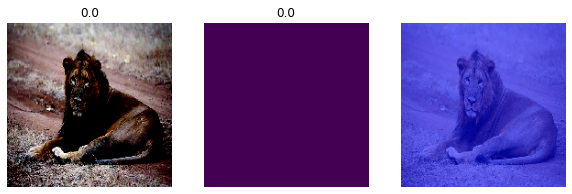

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


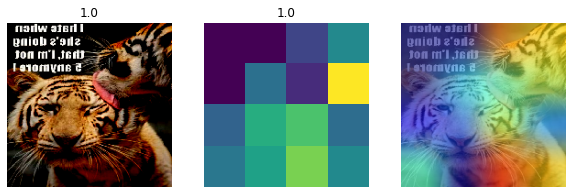

In [7]:
j=1
for i in range(2):
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(2, 3, j)
        #1. Original Image
        plt.imshow(image[i],vmin=0,vmax=255) 
        plt.title(label[i])
        plt.axis("off")
        
        #2. display the heatmap
        a = x_features[i,:,:,corr_list[0][0]]#select the first neuron of sorted correlation list
        ax = plt.subplot(2, 3, j+1)
        plt.imshow(a) #2. Heatmap
        plt.title(label[i])
        plt.axis("off")
        
        #3. Superimposed image code
        img = keras.preprocessing.image.img_to_array(image[i]) #preprocess the original image
        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * x_features[i,:,:,corr_list[0][0]])#select the first neuron of sorted correlation list

        # colorize heatmap using jet
        jet = cm.get_cmap("jet")
        jet_1 = jet(np.arange(256))[:, :3]
        jet_2 = jet_1[heatmap]

        # Create an image with RGB colorized heatmap
        jet_2 = keras.preprocessing.image.array_to_img(jet_2)
        jet_2 = jet_2.resize((img.shape[1], img.shape[0]))
        jet_2 = keras.preprocessing.image.img_to_array(jet_2)

        # Superimpose the heatmap on original image
        superimposed = jet_2 * 0.01 + img
        superimposed = keras.preprocessing.image.array_to_img(superimposed)
        ax = plt.subplot(2, 3, j+2)
        plt.imshow(superimposed,vmin=0,vmax=255) #3. Superimposed image
        plt.axis("off")
        plt.show()

#### Example 2 (2nd Neuron with highest correlation)
The tiger images shows the features highlighted in red and blue.
The lion images shows the features highlighted in yellow.
This neuron is showing the object detection very nicely and it is clearly able to differentiate between the two classes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


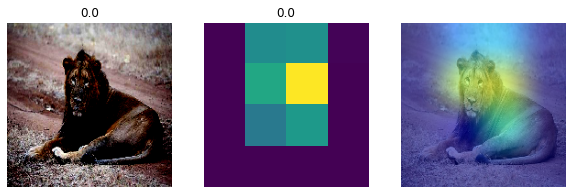

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


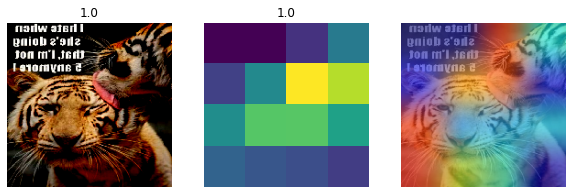

In [8]:
j=1
for i in range(2):
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(2, 3, j)
        #1. Original Image
        plt.imshow(image[i],vmin=0,vmax=255)
        plt.title(label[i])
        plt.axis("off")
        
        #2. display the heatmap
        a = x_features[i,:,:,corr_list[1][0]]#select the second neuron of sorted correlation list
        ax = plt.subplot(2, 3, j+1)
        plt.imshow(a)
        plt.title(label[i])
        plt.axis("off")
        
        #3. Superimposed image code
        img = keras.preprocessing.image.img_to_array(image[i]) #preprocess the original image
        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * x_features[i,:,:,corr_list[1][0]])#select the second neuron of sorted correlation list

        # colorize heatmap using jet
        jet = cm.get_cmap("jet")
        jet_1 = jet(np.arange(256))[:, :3]
        jet_2 = jet_1[heatmap]

        # Create an image with RGB colorized heatmap
        jet_2 = keras.preprocessing.image.array_to_img(jet_2)
        jet_2 = jet_2.resize((img.shape[1], img.shape[0]))
        jet_2 = keras.preprocessing.image.img_to_array(jet_2)

        # Superimpose the heatmap on original image
        superimposed = jet_2 * 0.01 + img
        superimposed = keras.preprocessing.image.array_to_img(superimposed)
        ax = plt.subplot(2, 3, j+2)
        plt.imshow(superimposed,vmin=0,vmax=255)
        plt.axis("off")
        plt.show()

#### Example 3 (3rd Neuron with highest correlation)
The tiger images shows the features highlighted in blue.
The lion images shows the features highlighted in red.
This neuron is also able to differentiate between the two classes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


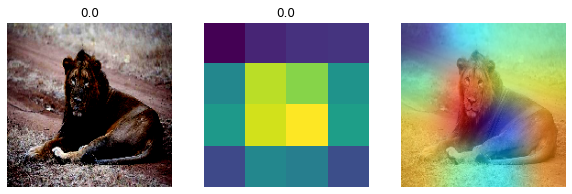

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


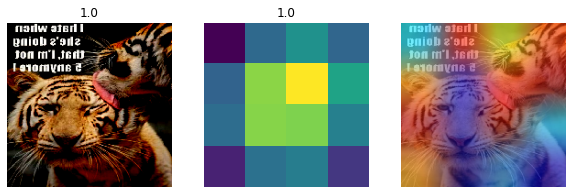

In [9]:
j=1
for i in range(2):
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(2, 3, j)
       #1. Original Image
        plt.imshow(image[i],vmin=0,vmax=255)
        plt.title(label[i])
        plt.axis("off")
        
        #2. display the heatmap
        a = x_features[i,:,:,corr_list[2][0]]#select the third neuron of sorted correlation list
        ax = plt.subplot(2, 3, j+1)
        plt.imshow(a)
        plt.title(label[i])
        plt.axis("off")

        #3. Superimposed image code
        img = keras.preprocessing.image.img_to_array(image[i]) #preprocess the original image
        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * x_features[i,:,:,corr_list[2][0]])#select the third neuron of sorted correlation list

        # colorize heatmap using jet
        jet = cm.get_cmap("jet")
        jet_1 = jet(np.arange(256))[:, :3]
        jet_2 = jet_1[heatmap]

        # Create an image with RGB colorized heatmap
        jet_2 = keras.preprocessing.image.array_to_img(jet_2)
        jet_2 = jet_2.resize((img.shape[1], img.shape[0]))
        jet_2 = keras.preprocessing.image.img_to_array(jet_2)

        # Superimpose the heatmap on original image
        superimposed = jet_2 * 0.01 + img
        superimposed = keras.preprocessing.image.array_to_img(superimposed)
        ax = plt.subplot(2, 3, j+2)
        plt.imshow(superimposed,vmin=0,vmax=255)
        plt.axis("off")
        plt.show()

#### References

[1] https://github.com/deliton/idt

[2] https://keras.io/examples/vision/grad_cam/

[3] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

[4] https://blog.paperspace.com/popular-deep-learning-architectures-resnet-inceptionv3-squeezenet/#:~:text=Inception%20v3%20was%20trained%20on,rates%20compared%20to%20its%20contemporaries.

[5] https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

[6] https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html